# Zombie Apocalypse Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

A ***World*** has:
 - A side length
 - A map generated with size side_length * side_length

In [2]:
class World:
    def __init__(self, side_length = 40):
        self.side_length = side_length
        self.map = np.zeros([side_length, side_length], dtype = 'object')
        for y in range(side_length):
            for x in range(side_length):
                house = House(x, y)
                self.map[y][x] = house
        self.people_list = []
                
    def get_side_length(self):
        return self.side_length
    
    def get_map(self):
        return self.map   

A ***House*** has:
 - A list of inhabitants (humans and zombies)
 - An x coordinate
 - A y coordinate

In [3]:
class House:
    def __init__(self, x, y):
        self.people = []
        self.x = x
        self.y = y
        
    def contents(self):
        return self.people

A ***Person*** has:
 - An x coordinate
 - A y coordinate
 - A property to tell if a person is infected
 - A property to tell if a person has been infected before
 - A method that allows a person to move on the map

In [4]:
class Person:
    def __init__(self, x, y, infected = False, has_been_infected = False):
        self.x = x
        self.y = y
        self.infected = infected
        self.has_been_infected = False
        self.moves = ["n", "ne", "e", "se", "s", "sw", "w", "nw", "na"]

    def getx(self):
        return self.x
        
    def gety(self):
        return self.y
    
    def is_zombie(self):
        if self.infected == True:
            return True
        return False
    
    def n(self, world):
        if self.gety() == 0:
            world.map[world.side_length-1][self.getx()].contents().append(self)
            world.map[self.gety()][self.getx()].contents().remove(self)
            self.y = world.side_length - 1
        else:
            world.map[self.gety()-1][self.getx()].contents().append(self)
            world.map[self.gety()][self.getx()].contents().remove(self)
            self.y = self.gety() - 1
                
    def e(self, world):
        if self.getx() == world.side_length - 1:
            world.map[self.gety()][0].contents().append(self)
            world.map[self.gety()][self.getx()].contents().remove(self)
            self.x = 0
        else:
            world.map[self.gety()][self.getx()+1].contents().append(self)
            world.map[self.gety()][self.getx()].contents().remove(self)
            self.x = self.getx() + 1
    
    def s(self, world):
        if self.gety() == world.side_length - 1:
            world.map[0][self.getx()].contents().append(self)
            world.map[self.gety()][self.getx()].contents().remove(self)
            self.y = 0
        else:
            world.map[self.gety()+1][self.getx()].contents().append(self)
            world.map[self.gety()][self.getx()].contents().remove(self)
            self.y = self.gety() + 1
        
    def w(self, world):
        if self.getx() == 0:
            world.map[self.gety()][world.side_length - 1].contents().append(self)
            world.map[self.gety()][self.getx()].contents().remove(self)
            self.x = world.side_length - 1
        else:
            world.map[self.gety()][self.getx()-1].contents().append(self)
            world.map[self.gety()][self.getx()].contents().remove(self)
            self.x = self.getx() -1
        
    def move(self, world):
        move = np.random.choice(self.moves)
        
        if move == "na":
            pass
        
        elif move == "n":
            self.n(world)
   
        elif move == "ne":
            self.n(world)
            self.e(world)
        
        elif move == "e":
            self.e(world)
                
        elif move == "se":
            self.s(world)
            self.e(world)
        
        elif move == "s":
            self.s(world)
            
        elif move == "sw":
            self.s(world)
            self.w(world)
        
        elif move == "w":
            self.w(world)
            
        elif move == "nw":
            self.n(world)
            self.w(world)

A ***Simulation*** has:
 - A method to start the simulation
 - A method to generate a scatter plot
 - A method to calculate how many people have been turned into zombies
 - A method to display the grid

In [5]:
class Simulation:
    def __init__(self, days = 1000, people = 100, remission = 0, side_length = 40):
        self.days = days
        self.people = people
        self.remission = remission
        self.world = World(side_length)
        self.currentDay = 0
        self.all_turned = False
        self.z_day = None
        self.zombie_population = np.zeros(days)
        self.infection_rate = np.zeros(days)
        self.daily_infected = np.zeros(days) #number of people becoming infected per day
        self.zombie_counter = 0
        
    def generate_start(self): #this funtion intitialises the person distribution and randomly distributes 1 zombie
        world = self.world.get_map()
        for i in range(self.people-1):
            person = Person(np.random.choice(self.world.get_side_length(), 1)[0], np.random.choice(self.world.get_side_length(), 1)[0])
            world[person.gety()][person.getx()].contents().append(person)
            self.world.people_list.append(person)
    
        zombie = Person(np.random.choice(self.world.get_side_length(), 1)[0], np.random.choice(self.world.get_side_length(), 1)[0], infected = True)
        world[zombie.gety()][zombie.getx()].contents().append(zombie)     
        self.world.people_list.append(zombie)
        
    def next(self, num_days = 1): #performs calculations and actions for incrementing a day
        for i in range(num_days):
            for row in self.world.map:
                for house in row:
                    cond = False #if there is at least 1 zombie in the house
                    for person in house.contents():
                        if person.is_zombie():
                            cond = True
                    if cond:
                        for person in house.contents():
                            if person.is_zombie() == False:
                                person.infected = True
                                self.daily_infected[self.currentDay] += 1
                                
                    for person in house.contents(): #spontaneously return to being human
                        if person.is_zombie():
                            come_back_to_LIFE = np.random.choice([True, False], size = None, p = [self.remission, 1 - self.remission])
                            if come_back_to_LIFE == True:
                                person.infected = False
                                self.daily_infected[self.currentDay] -= 1
                                
            for person in self.world.people_list:
                person.move(self.world)
   
            if self.all_turned == False: #keeps track of the day when the last human becomes infected
                if self.calculate_pop() == self.people:
                    self.all_turned = True
                    self.z_day = self.currentDay
                else:
                    self.all_turned = False 
            self.currentDay += 1
        
          
    def gen_scatter(self): #generates a scatter plot representation of the world
        for person in self.world.people_list:
            if person.is_zombie() == True:
                plt.scatter(person.getx(), person.gety(), c = 'g', alpha = 0.5)
            else:
                plt.scatter(person.getx(), person.gety(), c = 'b', alpha = 0.5)
        plt.xlim(0, self.world.get_side_length())
        plt.ylim(0, self.world.get_side_length())
        plt.title('World Side Length = {}'.format(self.world.get_side_length()))
        plt.xlabel('Side X')
        plt.ylabel('Side Y')
        plt.show()
        
    def calculate_pop(self): #returns the number of zombies in the world at the current time
        self.zombie_counter = 0
        for person in self.world.people_list:
            if person.is_zombie():
                self.zombie_counter += 1
        return self.zombie_counter
        
    def show(self): #print representation of the grid
        for row in self.world.map: 
            temp = []
            for house in row:
                temp_list = []
                if len(house.contents()) == 0:
                    temp_list.append('-')
                for person in house.contents():
                    if person.is_zombie() == True:
                        temp_list.append('Z')
                    elif person.is_zombie() == False:
                        temp_list.append('H')
                temp_list = ''.join(temp_list)
                temp.append(temp_list)
            temp = ' '.join(temp)
            print(temp)

In [6]:
#intialise 10 simulation runs

simulations = []

for i in range(10): #each simulation
    sim = Simulation(1000, 100, 0, 40)
    sim.generate_start()
    for j in range(1000): #each day in each simulation
        sim.zombie_population[j] = sim.calculate_pop()
        sim.next(1)
    simulations.append(sim)

## (1.1) 
*What is the average length of time until the last human gets infected? Provide also an estimate of the uncertainty in your value.*

In [7]:
z_day_list = []

for sim in simulations:
    z_day_list.append(sim.z_day)
    
z_day_average = np.mean(z_day_list)

print("For 10 simulations, the average number of days until last human becomes infected is {}".format(z_day_average))
print("This value changes based on the simulation generation. We can estimate the actual value at +- approximately 15 days.")

For 10 simulations, the average number of days until last human becomes infected is 318.8
This value changes based on the simulation generation. We can estimate the actual value at +- approximately 15 days.


## (1.2)
*Averaging over many runs, plot the number of zombies as a function of time.*

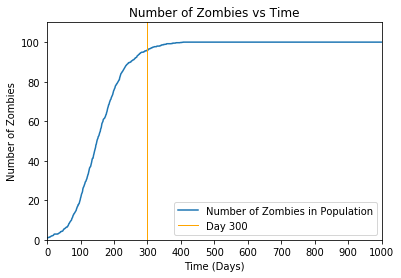

In [8]:
zombie_pop = np.zeros(1000)

for sim in simulations:
    for i in range(1000):
        zombie_pop[i] += sim.zombie_population[i]
        
zombie_pop = zombie_pop / 10  
    
plt.plot(zombie_pop, label = "Number of Zombies in Population")
plt.xlabel("Time (Days)")
plt.ylabel("Number of Zombies")
plt.title("Number of Zombies vs Time")
plt.axvline(x = 300, linewidth = 1, color = 'orange', label = "Day 300")
plt.xticks(np.arange(0, 1001, step = 100))
plt.ylim(0, 110)
plt.legend()
plt.xlim(0, 1001)
plt.show()

## (1.3) 
*Averaging over many runs, plot the number of infections per day (the infection rate) as a function of the fraction of zombies in the population.*

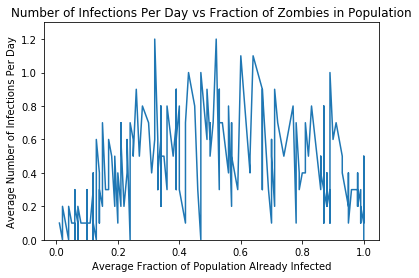

In [9]:
infection_rates = np.zeros(1000)
infection_fractions = np.zeros(1000)

for sim in simulations:
    for i in range(1000):
        infection_rates[i] += sim.daily_infected[i]
        infection_fractions[i] = (sim.zombie_population[i]/100) * 10

infection_rates = infection_rates/10 #average new zombies per day of simulation
infection_fractions = infection_fractions/10

plt.plot(infection_fractions, infection_rates)
plt.ylabel("Average Number of Infections Per Day")
plt.xlabel("Average Fraction of Population Already Infected")
plt.title("Number of Infections Per Day vs Fraction of Zombies in Population")
plt.ylim(0, 1.3)
plt.show()

### (1.4)
*Given your results in (1.3), postulate a discrete map for the zombie fraction (Z), i.e. Z(n+1) = f(Zn, tn)*

Since the plot in 1.3 is parabolic in nature, we can posulate a parabolic discrete map formula:<br>

***<center>y = a(x - h)^2 + k<center>***<br>


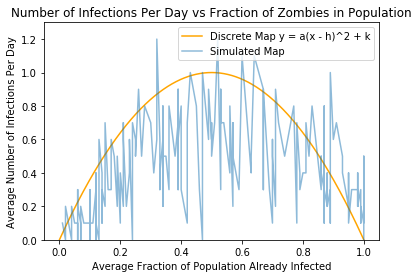

In [10]:
x = np.linspace(0.0, 1.0, 1000)
y = np.zeros(1000)

for i in range(1000):
    y[i] = -4*(x[i]-0.5)**2 + 1

plt.plot(x, y, color = 'orange', fillstyle = "full", label = "Discrete Map y = a(x - h)^2 + k")
plt.plot(infection_fractions, infection_rates, label = "Simulated Map", alpha = 0.5)
plt.ylabel("Average Number of Infections Per Day")
plt.xlabel("Average Fraction of Population Already Infected")
plt.title("Number of Infections Per Day vs Fraction of Zombies in Population")
plt.ylim(0, 1.3)
plt.legend()
plt.show()

## (1.5) 
*If you halve the size of the world (i.e, set side_length = 20), how does this change the time it takes until the last human is infected? Briefly discuss the real-world implications of this result.*

In [11]:
#running a new set of simulations with half the side length

simulations2 = []

for i in range(10): #each simulation
    sim = Simulation(1000, 100, 0, 20)
    sim.generate_start()
    for j in range(1000): #each day in each simulation
        sim.zombie_population[j] = sim.calculate_pop()
        sim.next(1)
    simulations2.append(sim)

In [12]:
#calculate average day until final infection

z_day_list2 = []

for sim in simulations2:
    z_day_list2.append(sim.z_day)
    
z_day_average2 = np.mean(z_day_list2)
    
print("For 10 simulations and side_length = 20, the average number of days until last human becomes infected is {}".format(z_day_average2))

For 10 simulations and side_length = 20, the average number of days until last human becomes infected is 68.6


As seen above in 1.5, the average time it takes to infect the last human (around 70 days) in a grid of 20 by 20 is around 4 to 5 times faster than in 1.1 (around 300 days) with a grid size of 40 by 40. <br>

This shows that spreadable dieseases or infections that exist in a smaller or more densely populated area such as a crowded hostpital or overflowing prisons will spread at a much faster rate than in open or sparsely populated areas.

## (1.6)

*Using the original size of the world (sidelength = 40), change the spontaneous zombie remission rate from 0 to 0.01 (i.e., every 100 days on average a given zombie will spontaneously return to being human).<br>*

*Discuss the new dynamics of the model, with reference to steady states
and/or equilibrium points (if you wish, you can also include a graph of the number of zombies over time to illustrate your point).<br>*

*Be careful to identify all possible types of behaviour (a “type” being a qualitatively distinct behaviour).*

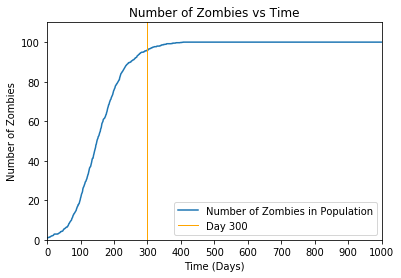

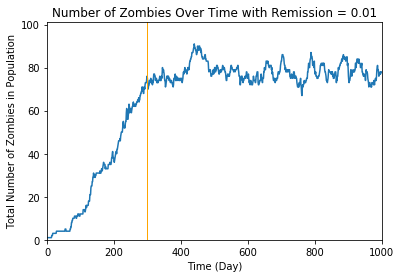

In [13]:
#generate one simulation with a remission rate of 0.01

rem_sim = Simulation(1000, 100, 0.01, 40)
rem_sim.generate_start()
rem_pop = np.zeros(1000)

for i in range(1000):
    rem_sim.zombie_population[i] = rem_sim.calculate_pop()
    rem_sim.next(1)
    rem_pop[i] += rem_sim.zombie_population[i]
    
#showing original zombie population vs time
    
plt.plot(zombie_pop, label = "Number of Zombies in Population")
plt.xlabel("Time (Days)")
plt.ylabel("Number of Zombies")
plt.title("Number of Zombies vs Time")
plt.axvline(x = 300, linewidth = 1, color = 'orange', label = "Day 300")
plt.xticks(np.arange(0, 1001, step = 100))
plt.ylim(0, 110)
plt.legend()
plt.xlim(0, 1001)
plt.show()

#running zombie population vs time with remission = 0.01

plt.plot(rem_pop)
plt.title("Number of Zombies Over Time with Remission = 0.01")
plt.axvline(x = 300, linewidth = 1, color = 'orange', label = "Day 300")
plt.xlabel("Time (Day)")
plt.ylabel("Total Number of Zombies in Population")
plt.ylim(0,101)
plt.xlim(0, 1001)
plt.show()

A steady state means that the map property does not change with time. <br>

When simulating with a remission rate of 0.01, the change in zombies over time becomes very different to the simulation without remission.<br> 

Here, we can observe that as the time increases, the rate of people turning into zombies slowly starts to reaches a constant peak around day 300 much like the previous experiment. After this point, the graph begins to fluctuate between around 70 to 90 zombies in the total population, but never flattens out like the previous graph. <br>

Instead, the simulation with remission never produces a smooth curve after reaching its peak. The remission rate causes the amount of zombies to flucuate constantly, so that the graph never reaches a constant value as time passes.

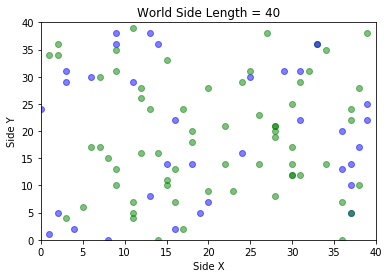

In [14]:
sim = Simulation(1000, 100, 0.01, 40) 
sim.generate_start() 
sim.next(350)
sim.gen_scatter()

If we take an experiment using a remission of 0.01, not all humans have been infected after 350 days, unlike the simulations run without the remission property where all humans had been infected by this time.<br>

The remission in these simulations effectivly models the presence of vaccines or cures to dieseases in the real world. If these exist, the spread of a virus can be slowed down tremendously.